# Assignment

In [1]:
# Import 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from Q_values import *


size_board = 4

np.random.seed(0)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [3 0 0 0]
 [0 0 1 2]
 [0 0 0 0]]
check?  0
dofk2  2

[[0 3 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 2 0]]
0  0
check?  0
dofk2  2

[[0 0 3 0]
 [0 0 0 0]
 [0 0 1 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 0 0 3]
 [0 0 0 0]
 [2 0 0 1]]
0  0
check?  0
dofk2  1

[[0 0 3 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 0]
 [2 0 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  1


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.195 Number of steps:  6.818


In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]                 ## INPUT SIZE
N_h=200                             ## NUMBER OF HIDDEN NODES
N_out = 8 * (size_board - 1) + 8    ## OUTPUT SIZE


## INITALISE YOUR NEURAL NETWORK...
W1 = np.random.uniform(-1, 1, [N_in, N_h]) / (N_in * N_h)
W2 = np.random.uniform(-1, 1, [N_h, N_out]) / (N_h * N_out)
bias_W1 = np.zeros([N_h])
bias_W2 = np.zeros([N_out])


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [6]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    # print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    if n % 2500 == 0 and n != 0:
        print(n, np.mean(R_save[:n]), np.mean(N_moves_save[:n]))
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        # a,_=np.where(allowed_a==1)
        # a_agent=np.random.permutation(a)[0]

        a, _ = np.where(allowed_a == 1)
        Q, X1 = Q_values(X, W1, W2, bias_W1, bias_W2)
        Q_allowed = np.copy(Q[a])

        if np.random.uniform(0, 1) < epsilon_f:     # random
            a_agent = np.random.permutation(a)[0]
        else:                                       # greedy
            at = np.argmax(Q_allowed)
            a_agent = a[at]


        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            delta = eta * (R - Q[a_agent])

            W2[:, a_agent] += delta * X1
            bias_W2 += delta

            W1 += delta * np.outer(X, W2[:, a_agent] * (X1 > 0))
            bias_W1 += delta * W2[:, a_agent] * (X1 > 0)


            R_save[n]=np.copy(R)
            N_moves_save[n]=np.copy(i)
            
            break
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            a_next, _ = np.where(allowed_a_next == 1)
            Q_next, _ = Q_values(X_next, W1, W2, bias_W1, bias_W2)
            Q_allowed_next = np.copy(Q_next[a_next])

            delta = eta * (R - Q[a_agent] + gamma * np.max(Q_allowed_next))

            W2[:, a_agent] += delta * X1
            bias_W2 += delta

            W1 += delta * np.outer(X, W2[:, a_agent] * (X1 > 0))
            bias_W1 += delta * W2[:, a_agent] * (X1 > 0)


        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


2500 0.3312 11.0372
5000 0.4064 11.7204
7500 0.43493333333333334 12.3588
10000 0.461 13.363
12500 0.48024 14.5344
15000 0.4946 15.1526
17500 0.5007428571428572 15.116114285714286
20000 0.5017 15.0409
22500 0.5001777777777778 14.69688888888889
25000 0.50772 14.33028
27500 0.5165454545454545 14.011236363636364
30000 0.5225666666666666 13.724
32500 0.5263076923076923 13.567846153846153
35000 0.532 13.391
37500 0.5455466666666666 13.24864
40000 0.5595 13.0219
42500 0.5738588235294118 12.680470588235295
45000 0.5877111111111111 12.365533333333333
47500 0.6006315789473684 12.087157894736842
50000 0.61178 11.83338
52500 0.6207238095238096 11.630895238095238
55000 0.63 11.3846
57500 0.6398260869565218 11.113982608695652
60000 0.6496666666666666 10.819616666666667
62500 0.658352 10.538864
65000 0.6663692307692307 10.2696
67500 0.6736296296296296 10.017703703703704
70000 0.6804714285714286 9.7847
72500 0.6878344827586207 9.57191724137931
75000 0.6943866666666667 9.37148
77500 0.7010709677419354 

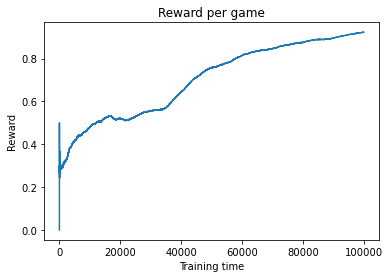

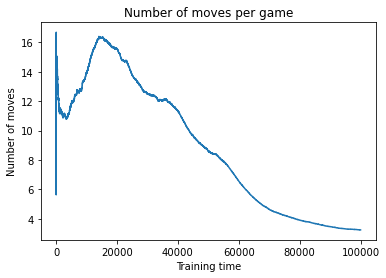

In [7]:
# Plot EMA of reward and number of moves
R_df = pd.DataFrame({'Reward': list(R_save)})
N_moves_df = pd.DataFrame({'Number of moves': list(N_moves_save)})

R_ema = R_df.ewm(com=10000).mean()
N_moves_ema = N_moves_df.ewm(com=10000).mean()

plt.plot(R_ema)
plt.title('Reward per game')
plt.xlabel('Training time')
plt.ylabel('Reward')
plt.show()

plt.plot(N_moves_ema)
plt.title('Number of moves per game')
plt.xlabel('Training time')
plt.ylabel('Number of moves')
plt.show()


In [8]:
# Implementation of Deep SARSA algorithm

import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# using GPU to accelerate training, which I think may cause the results not precisely reproducible on difference devices.
# I can only make sure it reproducible on my own device.
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
# Initialize environment and DNN

env = Chess_Env(size_board)
S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0] # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in = np.shape(X)[0]               ## INPUT SIZE
N_h = 200                           ## NUMBER OF HIDDEN NODES
N_out = 8 * (size_board - 1) + 8    ## OUTPUT SIZE

# HYPERPARAMETERS
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0005        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED
D_size = 200        # THE EXPERIENCE REPLAY SIZE
batch_size = 32     # THE MINI BATCH SIZE

## INITALISE DNN
# model = Sequential()
# model.add(Dense(16, activation='relu', input_shape=(N_in,)))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(N_out, activation='linear'))
# model.compile(loss='mse', optimizer=Adam(learning_rate=eta))
# model.summary()

## INITALISE DNN
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(N_in,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(N_out, activation='linear'))
model.compile(loss='mse', optimizer=Adam(learning_rate=eta))
model.summary()

# SAVING VARIABLES
d = 0       # EXPERIENCE REPLAY COUNTER
D_x = []    # EXPERIENCE REPLAY BUFFER
D_y = []    # EXPERIENCE REPLAY BUFFER
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3776      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
Total params: 6,912
Trainable params: 6,912
Non-trainable params: 0
_________________________________________________________________


In [10]:
# TRAINING LOOP

a, _ = np.where(allowed_a == 1)
Q = model.predict(np.array([X]))[0]
Q_allowed = np.copy(Q[a])

epsilon_f = epsilon_0

if np.random.uniform(0, 1) < epsilon_f:     # random
    a_agent = np.random.permutation(a)[0]
else:                                       # greedy
    at = np.argmax(Q_allowed)
    a_agent = a[at]

for n in range(N_episodes):
    # epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done = 0                                 ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

    if n % 2500 == 0 and n != 0:
        print(n, np.mean(R_save[:n]), np.mean(N_moves_save[:n]))

    while Done == 0:                         ## START THE EPISODE
        # mini-batch training
        if d == D_size:
            index = np.random.randint(D_size, size=batch_size)
            sample_x = np.array(D_x)[index]
            sample_y = np.array(D_y)[index]
            model.fit(sample_x, sample_y, verbose=0)

            d = 0
            D_x = []
            D_y = []

            epsilon_f = epsilon_0 / (1 + beta * n)

        # take action
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

        if Done == 1:
            Q[a_agent] = R
            D_x.append(np.copy(X))
            D_y.append(np.copy(Q))
            d += 1

            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)

            S, X, allowed_a = env.Initialise_game()  ## INITIALISE NEXT GAME

            a, _ = np.where(allowed_a == 1)
            Q = model.predict(np.array([X]))[0]
            Q_allowed = np.copy(Q[a])

            if np.random.uniform(0, 1) < epsilon_0:     # random
                a_agent = np.random.permutation(a)[0]
            else:                                       # greedy
                at = np.argmax(Q_allowed)
                a_agent = a[at]

            break

        else:
            # choose next action
            a_next, _ = np.where(allowed_a_next == 1)
            Q_next = model.predict(np.array([X_next]))[0]
            Q_allowed_next = np.copy(Q_next[a_next])

            if np.random.uniform(0, 1) < epsilon_f:     # random
                a_agent_next = np.random.permutation(a_next)[0]
            else:                                       # greedy
                at = np.argmax(Q_allowed_next)
                a_agent_next = a_next[at]

            Q[a_agent] = R + gamma * Q_next[a_agent_next]
            D_x.append(np.copy(X))
            D_y.append(np.copy(Q))
            d += 1


        # NEXT STATE AND CO. BECOME ACTUAL STATE...
        S = np.copy(S_next)
        X = np.copy(X_next)
        Q = np.copy(Q_next)
        a_agent = a_agent_next

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


2500 0.238 7.3324
5000 0.3238 7.0944
7500 0.37853333333333333 7.4516
10000 0.438 7.444
12500 0.47984 7.28704
15000 0.5192 7.083266666666667
17500 0.5475428571428571 6.870171428571428
20000 0.5762 6.64025
22500 0.6021777777777778 6.418222222222222
25000 0.623 6.21248
27500 0.6428727272727273 6.032290909090909
30000 0.6582333333333333 5.834366666666667
32500 0.6743384615384616 5.677661538461538
35000 0.6884285714285714 5.5558
37500 0.70208 5.435813333333333
40000 0.7138 5.322475
42500 0.7242352941176471 5.209835294117647
45000 0.7342 5.118288888888889
47500 0.743621052631579 5.038757894736842
50000 0.75236 4.95978
52500 0.7599809523809524 4.884228571428571
55000 0.7665818181818181 4.818163636363637
57500 0.7732347826086956 4.755739130434782
60000 0.77985 4.698783333333333
62500 0.785536 4.651376
65000 0.7912615384615385 4.599846153846154
67500 0.7965925925925926 4.5574666666666666
70000 0.8012571428571429 4.514157142857143
72500 0.8056965517241379 4.474827586206897
75000 0.81010666666666

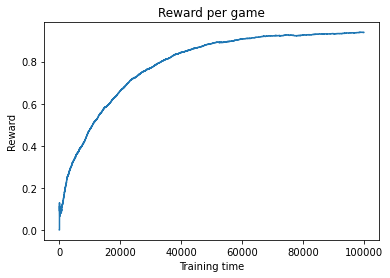

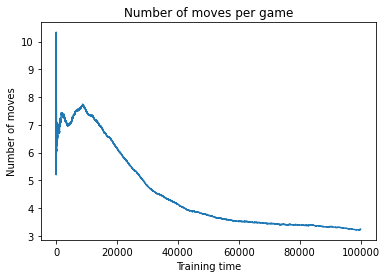

In [11]:
# Plot EMA of reward and number of moves
R_df = pd.DataFrame({'Reward': list(R_save)})
N_moves_df = pd.DataFrame({'Number of moves': list(N_moves_save)})

R_ema = R_df.ewm(com=10000).mean()
N_moves_ema = N_moves_df.ewm(com=10000).mean()

plt.plot(R_ema)
plt.title('Reward per game')
plt.xlabel('Training time')
plt.ylabel('Reward')
plt.show()

plt.plot(N_moves_ema)
plt.title('Number of moves per game')
plt.xlabel('Training time')
plt.ylabel('Number of moves')
plt.show()

